In [15]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data
from models.EdgeClassifier import EdgeClassNet
from torch.optim import Adam

In [16]:
# run only if new data is desired
ode_dim = 2
n_data = 4
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,10000)

dataset = []
for i in range(0,len(x_train)):

    y = torch.zeros(len(y_train[i]))
    for j in range(0,len(y_train[i])):
        if y_train[i][j] > 0.0001:
            y[j] = 1
        if y_train[i][j] < -0.0001:
            y[j] = 2
    y = y.long()
    dataset.append(to_pyg_data(x_train[i],y,ode_dim,n_data))

loader = DataLoader(dataset,batch_size=64,shuffle=True)

x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_data,128)

dataset = []
for i in range(0,len(x_test)):
    y = torch.zeros(len(y_test[i]))
    for j in range(0,len(y_test[i])):
        if y_test[i][j] > 0.0001:
            y[j] = 1
        if y_test[i][j] < -0.0001:
            y[j] = 2
    y = y.long()
    dataset.append(to_pyg_data(x_test[i],y,ode_dim,n_data))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)

In [17]:
model = EdgeClassNet(n_data, 20, ode_dim ** 2, 1)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()  # or MSELoss for regression
class_loss = torch.nn.NLLLoss()
reg = torch.nn.L1Loss()

train_loss = []
test_loss = []

# Training loop
for epoch in range(3000):
    model.train()

    tr_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)

        loss = class_loss(out,data.y)
        # loss = loss + 0.0001*reg(out.flatten(),0*out.flatten())
        train_loss.append(loss)

        loss.backward()
        optimizer.step()
        
        tr_loss += loss

    # print(tr_loss.item())

    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            loss = class_loss(out,data.y)
            # print(loss.item())
            test_loss.append(loss)
            print(loss.item())

0.9326632618904114
0.9339537024497986
0.9338076710700989
0.9329468607902527
0.9330031275749207
0.9324748516082764
0.9318847060203552
0.9325476288795471
0.9325652122497559
0.9317919015884399
0.9316866993904114
0.932746410369873
0.9292737245559692
0.9213719367980957
0.9148979187011719
0.913530707359314
0.9112617373466492
0.9151667356491089
0.9106073379516602
0.9138805270195007
0.9121809601783752
0.9106771349906921
0.9119512438774109
0.9108870029449463
0.909338653087616
0.912658154964447
0.910848081111908
0.9113965034484863
0.9074454307556152
0.9077810645103455
0.9085805416107178
0.9102051854133606
0.9096758961677551
0.909856915473938
0.9118668437004089
0.9121202826499939
0.9126728177070618
0.9116101861000061
0.9103738069534302
0.9115017652511597
0.9129684567451477
0.9120067358016968
0.9115842580795288


KeyboardInterrupt: 

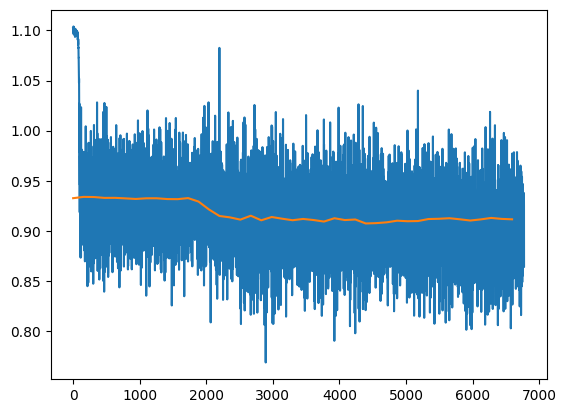

0.13
0.09
0.585
0.54


In [20]:
import matplotlib.pyplot as plt
from scipy.io import savemat

def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
tst_l = [test_loss[i].to('cpu').detach().numpy() for i in range(0,len(test_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.plot(range(0,len(loader)*len(tst_l),len(loader)),tst_l)
plt.show()

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,100)

val_dataset = []
param_list = []

for i in range(0,len(x_val)):
    p = param_val[i]
    param_vec = torch.cat((p.Win.flatten(), p.Wout.flatten(), p.bin, p.bout, p.gamma)).numpy()
    param_list.append(param_vec)
    val_dataset.append(to_pyg_data(x_val[i],y_val[i],ode_dim,n_data))

val_loader = DataLoader(val_dataset)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

changed = 0
fixed = 0
destroyed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    Ainit = get_adjacency(batch.edge_attr.t()[0])
    out = model(batch)
    Ahat = torch.zeros(ode_dim**2)
    for i in range(0,len(out)):
        mx = out[i].argmax()
        if mx == 1:
            Ahat[i] = 1
        if mx == 2:
            Ahat[i] = -1

    # Ahat = get_adjacency(model(batch)).t()[0]
    A = get_adjacency(batch.y)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1

    for i in range(0,len(Ainit)):
        if Ainit[i] != Ahat[i]:
            changed += 1
            if A[i] == Ahat[i]:
                fixed += 1
            if Ainit[i] == A[i]:
                destroyed += 1
    

    if sum(abs(Ainit-A)) < 0.001:
        init_correct = init_correct+1

    for i in range(0,len(A)):
        
        if abs(Ainit[i]-A[i]) < 0.001:
             elem_wise_init += 1

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1
            
        elems_total += 1

    
    
    mdic = {"Ainit":Ainit.numpy() ,"A":A.numpy() ,"Ahat":Ahat.numpy(),"x":batch.x.numpy(), "p": param_list[k]}
    k += 1
    filenm = "network"+str(k)+".mat"
    savemat(filenm,mdic)

print(correct/total)
print(init_correct/total)
print(elem_wise/elems_total)
print(elem_wise_init/elems_total)

In [22]:
print(fixed/changed)
print(destroyed/changed)

0.5188679245283019
0.3490566037735849
